In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
from IPython.display import display
from collections import defaultdict

## Training Loss over training epoches

In [222]:
def plot_loss_over_time(tsvf, output_path, title):
    df = pd.read_csv(tsvf, sep='\t')

    # Plot train_loss and val_loss
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['train_loss'], label='Train Normalized MSE')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Normalized MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Normalized MSE')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(output_path)

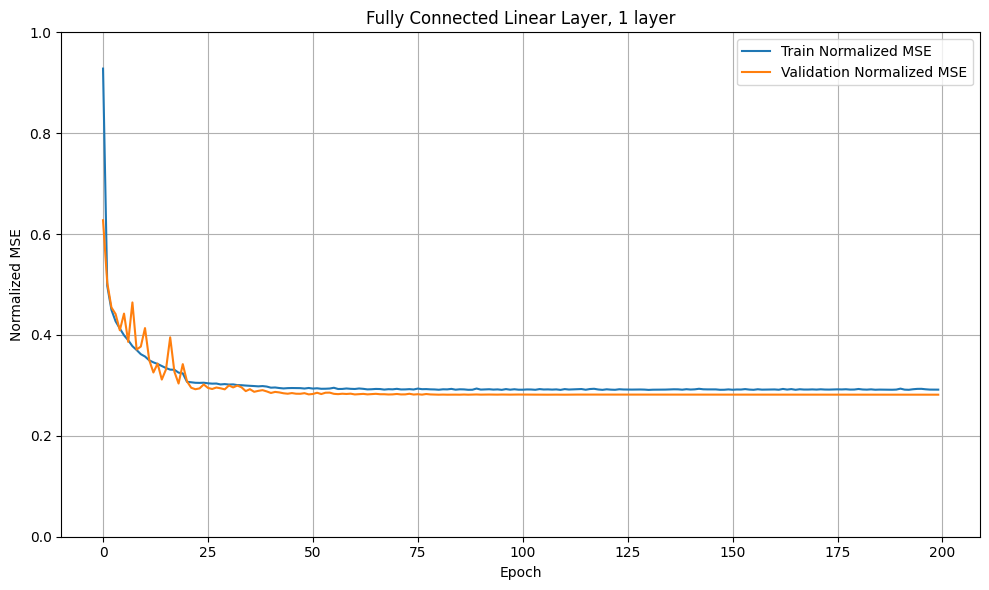

In [223]:
plot_loss_over_time('/home/zhaoyang-new/School_Work/cse251b_project/model_outs/linear/training_epoches.tsv', 'linear_loss_plot.png', 'Fully Connected Linear Layer, 1 layer')

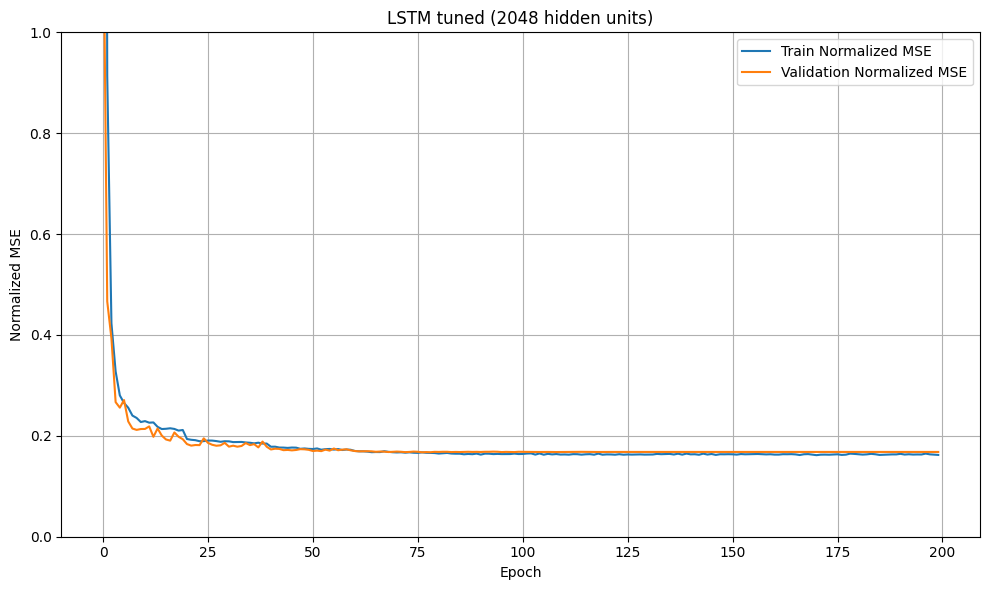

In [224]:
plot_loss_over_time('/home/zhaoyang-new/School_Work/cse251b_project/model_outs/LSTM_2048_tuned/training_epoches.tsv', 'LSTM_tuned_loss_plot.png', 'LSTM tuned (2048 hidden units)')

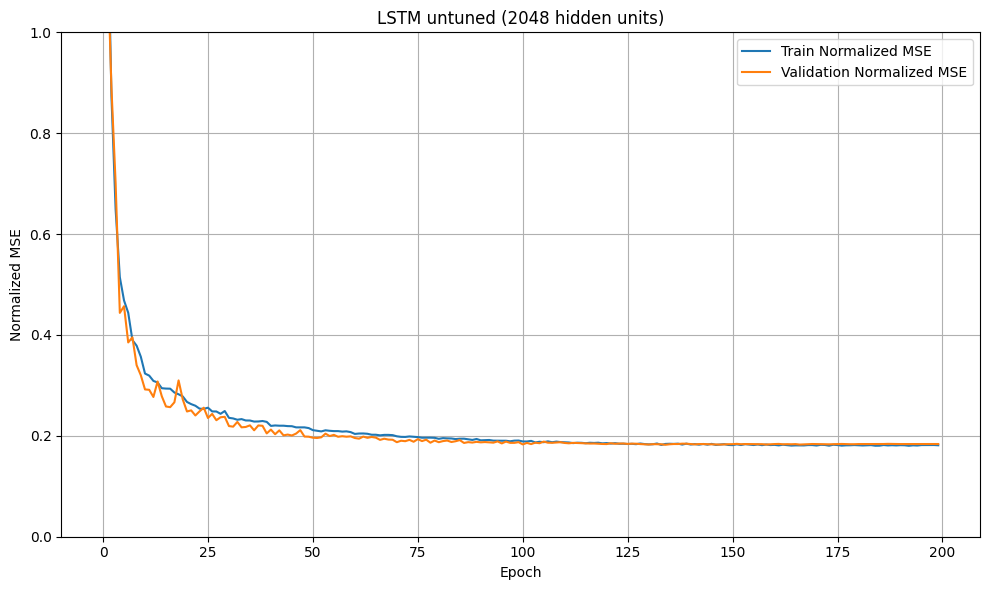

In [225]:
plot_loss_over_time('/home/zhaoyang-new/School_Work/cse251b_project/model_outs/LSTM_2048_untuned/training_epoches.tsv', 'LSTM_untuned_loss_plot.png', 'LSTM untuned (2048 hidden units)')

## Finding good prediction cases vs. bad cases
Need to first run predict on testing dataset to get the (x,y) predicted from testing dataset, then use this section to compare against the labels

In [14]:
train_file = np.load('../source/src_data/train.npz')
train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('../source/src_data/test_input.npz')
test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


In [132]:
def gather_training_loss(predf):
    pred_df = pd.read_csv(predf, sep=',', index_col='index')
    labels = train_data[:, :1, 50:, :2]
    # Compress the first three dimensions into one
    labels = labels.reshape(-1, 2)
    labels_df = pd.DataFrame(labels, columns=['x_label', 'y_label'])
    df = pd.concat([pred_df, labels_df], axis=1)
    df['x_se'] = (df['x'] - df['x_label']) ** 2
    df['y_se'] = (df['y'] - df['y_label']) ** 2
    
    scene_mse = []
    se_sum = 0.0
    scene_id = 0
    for row_idx, row in df.iterrows():
        if row_idx != 0 and row_idx % 60 == 0:
            mse = se_sum / 120
            scene_mse.append((mse, scene_id))
            se_sum = 0.0
        scene_id = row_idx // 60
        se_sum += row['x_se'] + row['y_se']
    mse = se_sum / 120
    scene_mse.append((mse, scene_id))
    scene_mse.sort()
    
    ## slice the dfs for each scene
    scene_dfs = {}
    for idx, i in enumerate(range(0, 600000, 60)):
        scene_dfs[idx] = df.iloc[i: i+60]
    
    return df, scene_mse, scene_dfs

In [141]:
lstm_df, lstm_mse, lstm_scenes = gather_training_loss('../train_predictions.csv')

In [134]:
linear_df, linear_mse, linear_scenes = gather_training_loss('/home/zhaoyang-new/School_Work/cse251b_project/model_outs/linear/predicts_training.tsv')

In [185]:
ar_df, ar_mse, ar_scenes = gather_training_loss('/home/zhaoyang-new/School_Work/cse251b_project/model_outs/test_AR/predicts_training.tsv')

## Plotting prediction results

In [125]:
obj_types = ['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus', 'static', 'background', 'construction', 'riderless_bicycle', 'unknown']
obj_mapping = {idx: obj for idx, obj in enumerate(obj_types)}

# Assign each object type a distinct color
type_colors = {
    'vehicle': 'blue',
    'pedestrian': 'red',
    'motorcyclist': 'cyan',
    'cyclist': 'pink',
    'bus': 'brown',
    'static': 'gray',
    'background': 'black',
    'construction': 'yellow',
    'riderless_bicycle': 'pink',
    'unknown': 'magenta'
}

In [126]:
def make_gif(data_matrix, name='example'):
    fig, ax = plt.subplots(figsize=(10, 10))

    def update(frame):
        ax.clear()

        # Plot non-ego agents
        for i in range(1, data_matrix.shape[0] - 1):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]
                ys = data_matrix[i, :frame+1, 1]
                mask = (xs != 0) & (ys != 0)
                xs = xs[mask]
                ys = ys[mask]

                if len(xs) > 0 and len(ys) > 0:
                    type_idx = int(data_matrix[i, 0, 5])
                    obj_type = obj_mapping.get(type_idx, 'unknown')
                    color = type_colors.get(obj_type, 'black')
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)

        # Plot ego agent
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1], color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1], s=80, color='tab:orange')

        ego_obj = obj_mapping[int(data_matrix[0, 0, 5])]
        ax.set_title(f'{name}')

        # Axis limits
        ax.set_xlim(data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].min() - 10,
                    data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].min() - 10,
                    data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].max() + 10)
        ax.legend()

        return ax.collections + ax.lines

    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

In [113]:
for k in range(5303, 5304):
    data_matrix = train_data[k]
    make_gif(data_matrix, f'index{k}')

In [213]:
def make_scene_png(data_matrix, name='example', frame=None):
    if frame is None:
        frame = data_matrix.shape[1] - 1  # default to final frame

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot other agents
    for i in range(1, data_matrix.shape[0]):
        xs = data_matrix[i, :frame + 1, 0]
        ys = data_matrix[i, :frame + 1, 1]
        mask = (xs != 0) & (ys != 0)
        xs = xs[mask]
        ys = ys[mask]

        if len(xs) > 0:
            type_idx = int(data_matrix[i, 0, 5])
            obj_type = obj_mapping.get(type_idx, 'unknown')
            color = type_colors.get(obj_type, 'black')
            ax.plot(xs, ys, alpha=0.9, color=color)
            ax.scatter(xs[-1], ys[-1], s=80, color=color)  # latest position

    # Plot ego agent
    ego_xs = data_matrix[0, :frame + 1, 0]
    ego_ys = data_matrix[0, :frame + 1, 1]
    ego_mask = (ego_xs != 0) & (ego_ys != 0)
    ego_xs = ego_xs[ego_mask]
    ego_ys = ego_ys[ego_mask]
    ax.plot(ego_xs, ego_ys, color='tab:orange', label='Ego Vehicle')
    ax.scatter(ego_xs[-1], ego_ys[-1], s=80, color='tab:orange')
    
    # Plot ego pred
    ego_xs = data_matrix[-1, :frame + 1, 0]
    ego_ys = data_matrix[-1, :frame + 1, 1]
    ego_mask = (ego_xs != 0) & (ego_ys != 0)
    ego_xs = ego_xs[ego_mask]
    ego_ys = ego_ys[ego_mask]
    ax.plot(ego_xs, ego_ys, color='tab:green', label='Predicted Ego Vehicle')
    ax.scatter(ego_xs[-1], ego_ys[-1], s=80, color='tab:green')

    ego_obj = obj_mapping[int(data_matrix[0, 0, 5])]
    ax.set_title(f'{name}')
    ax.set_xlim(data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].min() - 10,
                data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].max() + 10)
    ax.set_ylim(data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].min() - 10,
                data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].max() + 10)
    ax.legend()
    # plt.show()
    plt.savefig(f'{name}.png')
    plt.close()
    
def plot_scene_pred(scene_id, scenes, mses, title):
    train_data_matrix = train_data[scene_id]
    pred = np.array(scenes[scene_id][['x', 'y']].to_numpy())
    ## padding pred  2nd and 3rd dimension [0:50] = 0 and [2:6] = 0
    concat_matrix = np.zeros((51, 110, 6))
    concat_matrix[:50, :, :] = train_data_matrix
    pred_padded = np.pad(pred, [(0, 0), (0, 4)], mode='constant', constant_values=0)
    pred_padded = np.pad(pred_padded, [(0, 50), (0, 0)], mode='constant', constant_values=0)
    concat_matrix[50, :, :] = pred_padded
    mse = -1.0
    for m in mses:
        if m[1] == scene_id:
            mse = m[0]
            break
    
    make_scene_png(concat_matrix, f"{title} (mse={mse})")


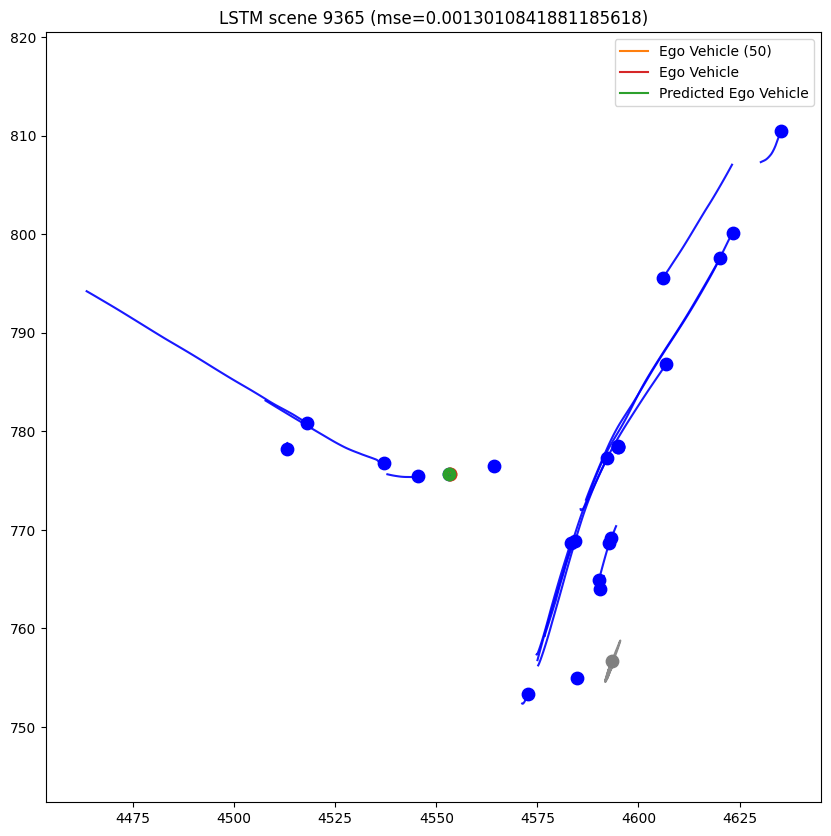

In [142]:
## predictions on stationary agent is very accurate
s = 9365
plot_scene_pred(s, lstm_scenes, lstm_mse, f'LSTM scene {s}') 

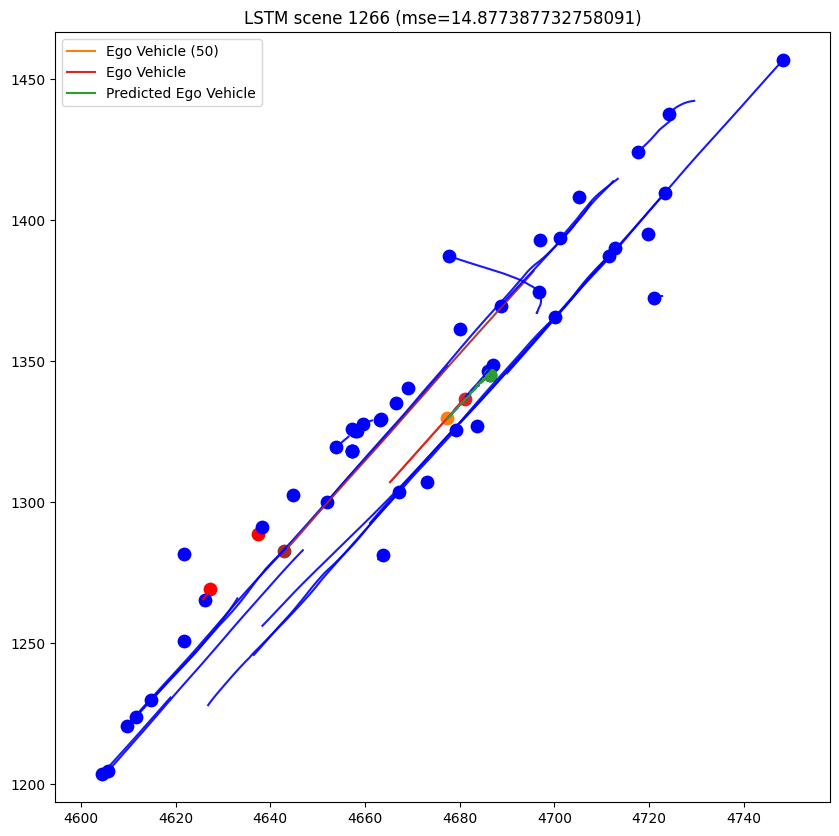

In [143]:
## current model ignores collision
s = 1266
plot_scene_pred(s, lstm_scenes, lstm_mse, f'LSTM scene {s}') 

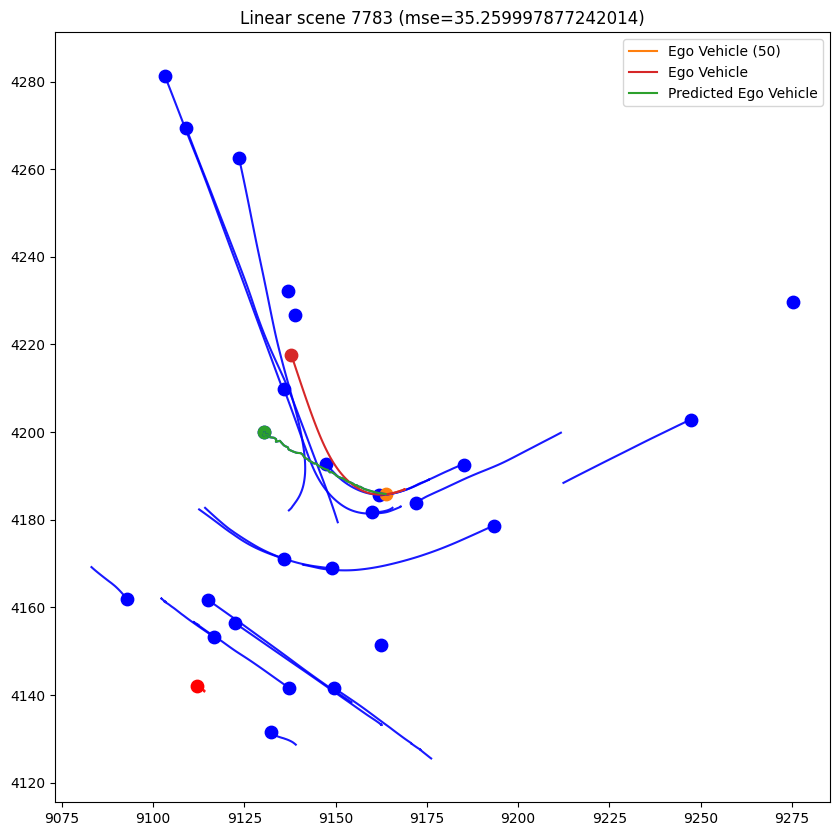

In [145]:
## linear model lacks predictive power on complex curves 
s = 7783
plot_scene_pred(s, lstm_scenes, lstm_mse, f'Linear scene {s}') 

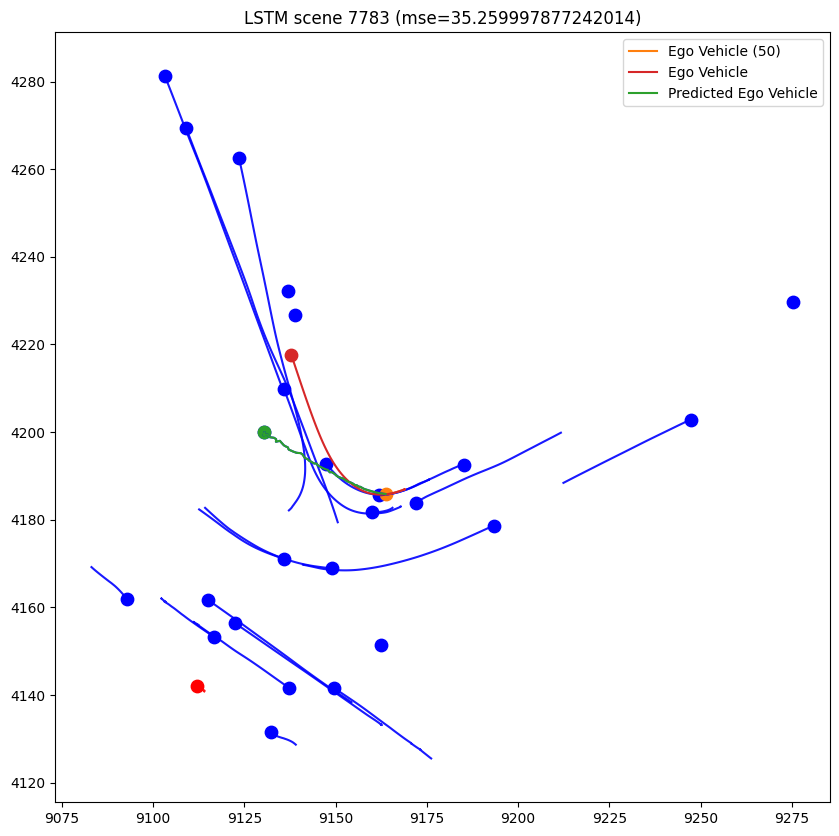

In [146]:
## linear model lacks predictive power on complex curves
s = 7783
plot_scene_pred(s, lstm_scenes, lstm_mse, f'LSTM scene {s}') 

In [197]:
## linear model lacks predictive power on complex curves
s = 1954
plot_scene_pred(s, linear_scenes, linear_mse, f'Linear scene {s}') 

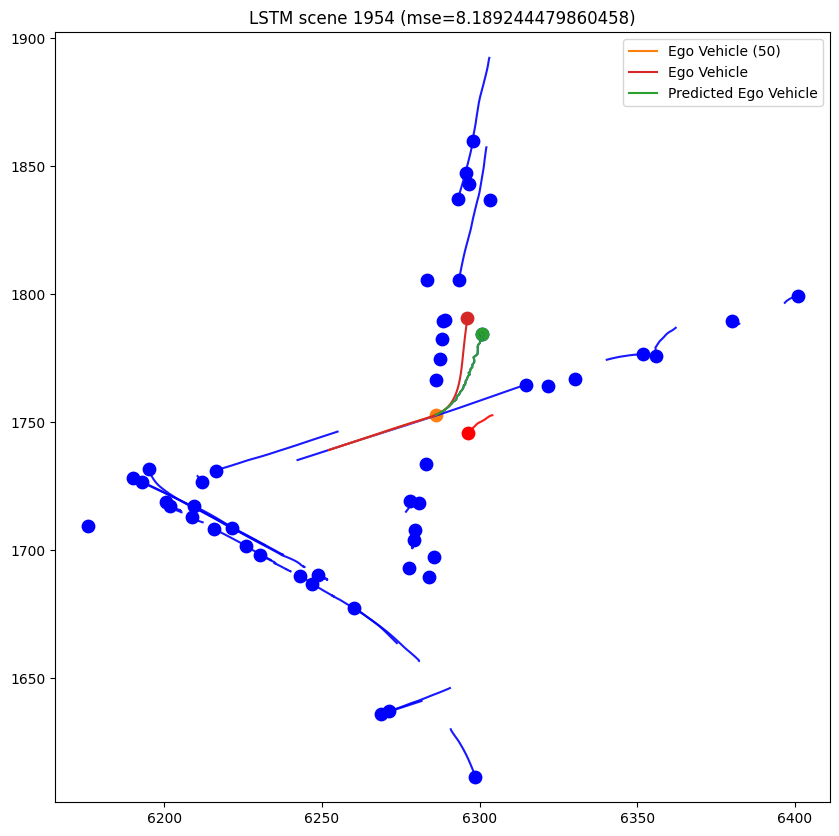

In [147]:
## linear model lacks predictive power on complex curves
s = 1954
plot_scene_pred(s, lstm_scenes, lstm_mse, f'LSTM scene {s}') 

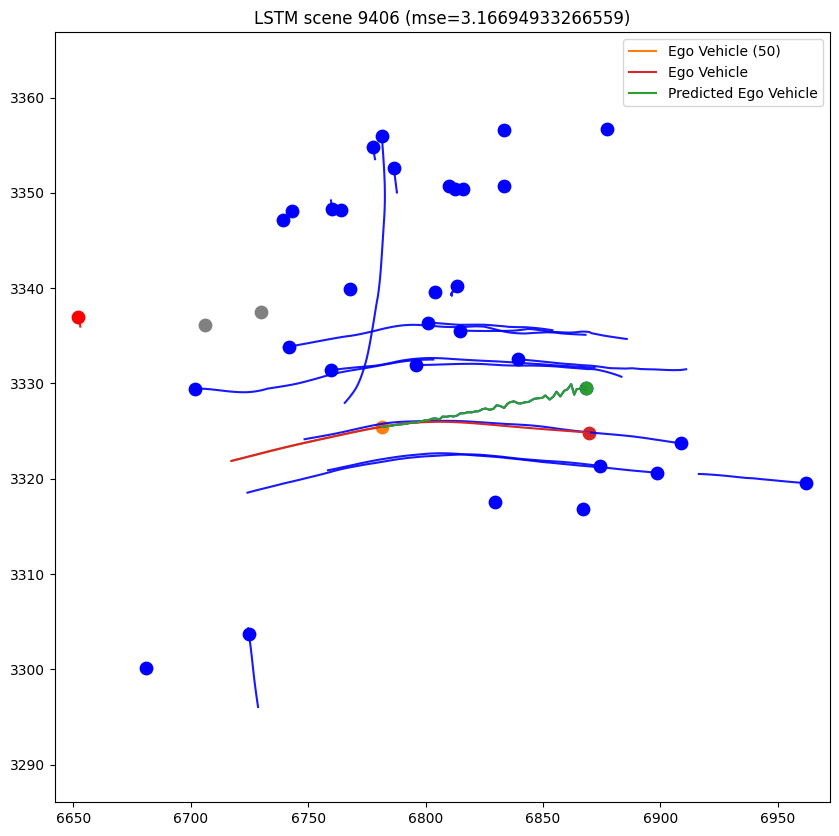

In [148]:
## potential feature engineering to normalize the dataset axes magnitude
s = 9406
plot_scene_pred(s, lstm_scenes, lstm_mse, f'LSTM scene {s}') 

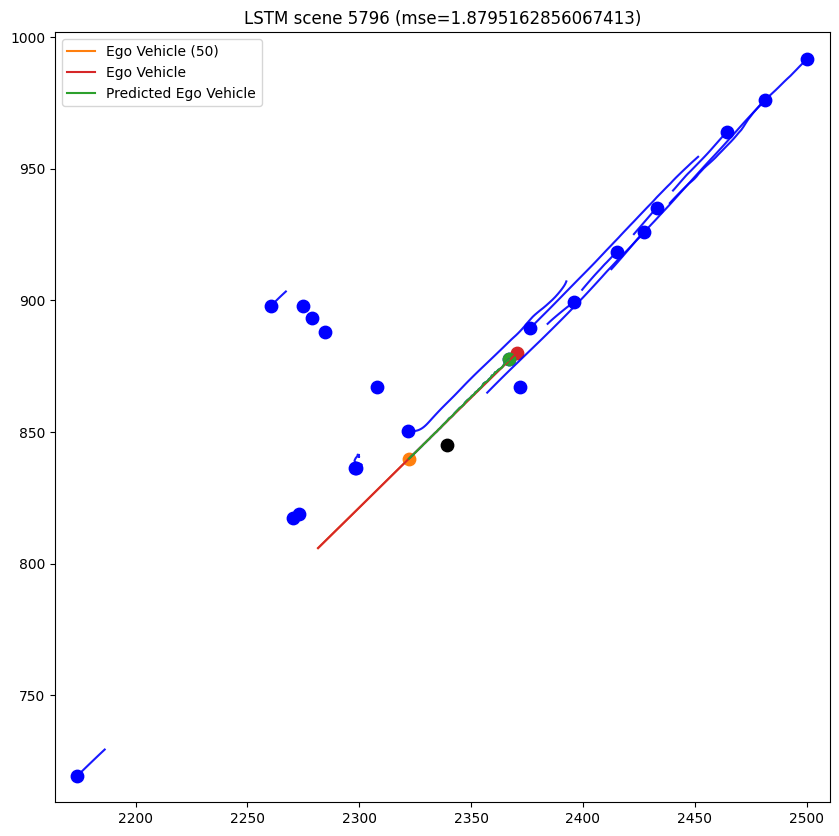

In [149]:
## potential feature engineering to normalize the dataset axes magnitude
s = 5796
plot_scene_pred(s, lstm_scenes, lstm_mse, f'LSTM scene {s}') 

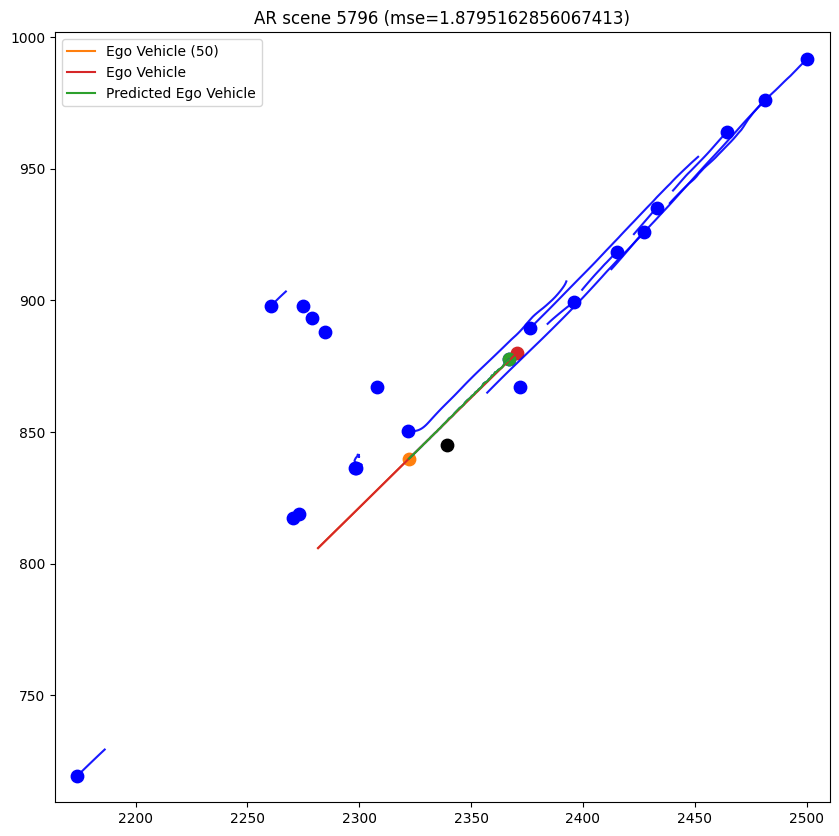

In [150]:
## AR is over-predicting stopped agent
s = 5796
plot_scene_pred(s, lstm_scenes, lstm_mse, f'AR scene {s}') 

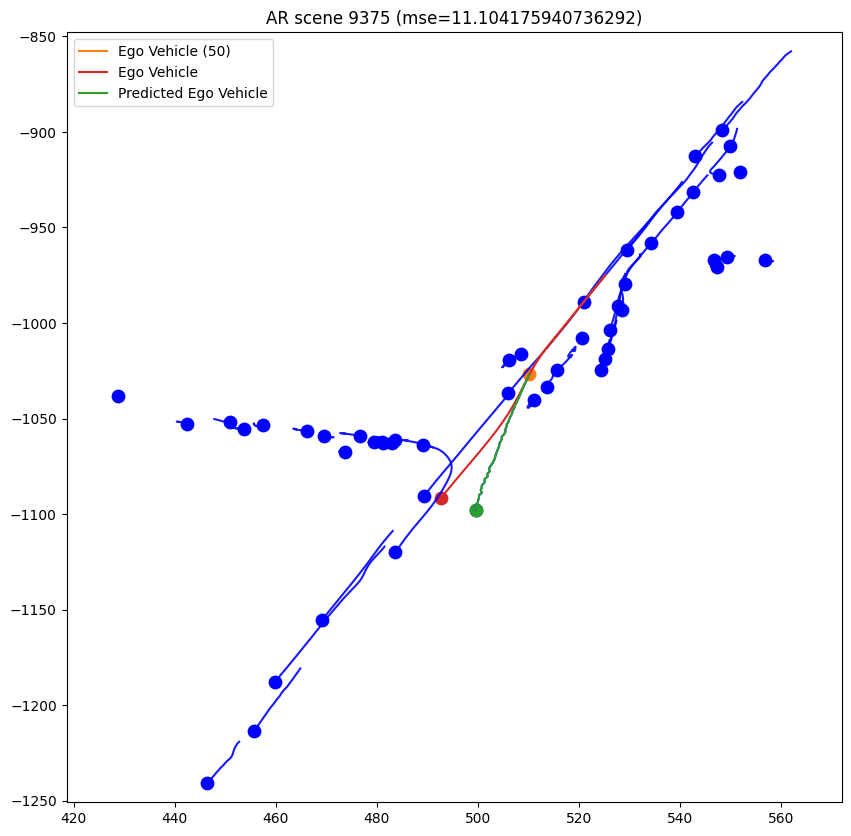

In [151]:
## AR is over-predicting stopped agent
s = 9375
plot_scene_pred(s, lstm_scenes, lstm_mse, f'AR scene {s}') 

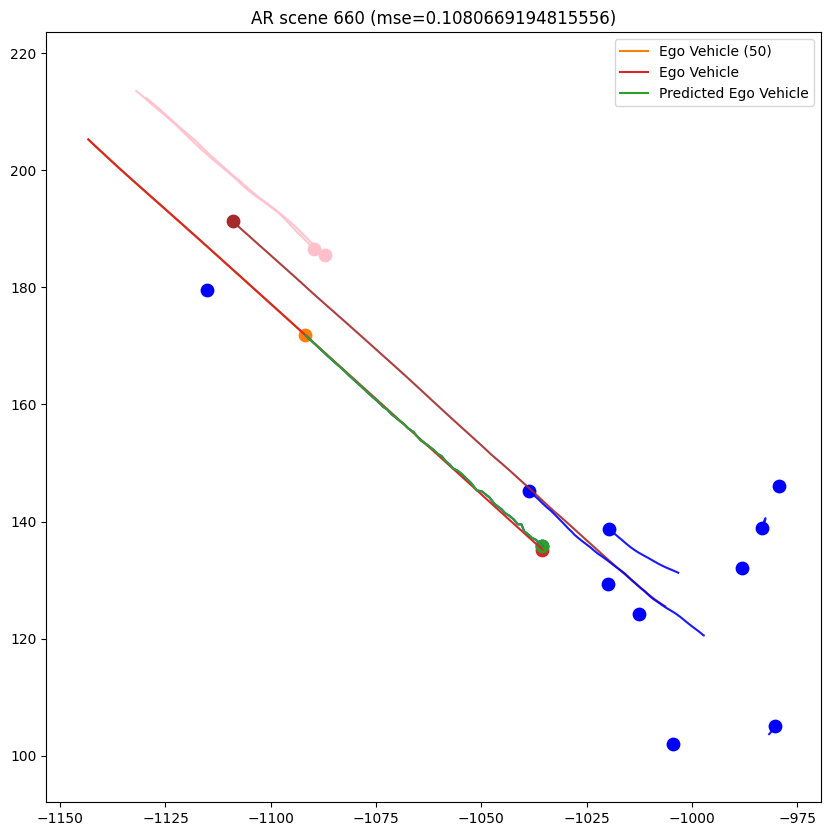

In [152]:
## AR is over-predicting stopped agent
s = 660
plot_scene_pred(s, lstm_scenes, lstm_mse, f'AR scene {s}') 

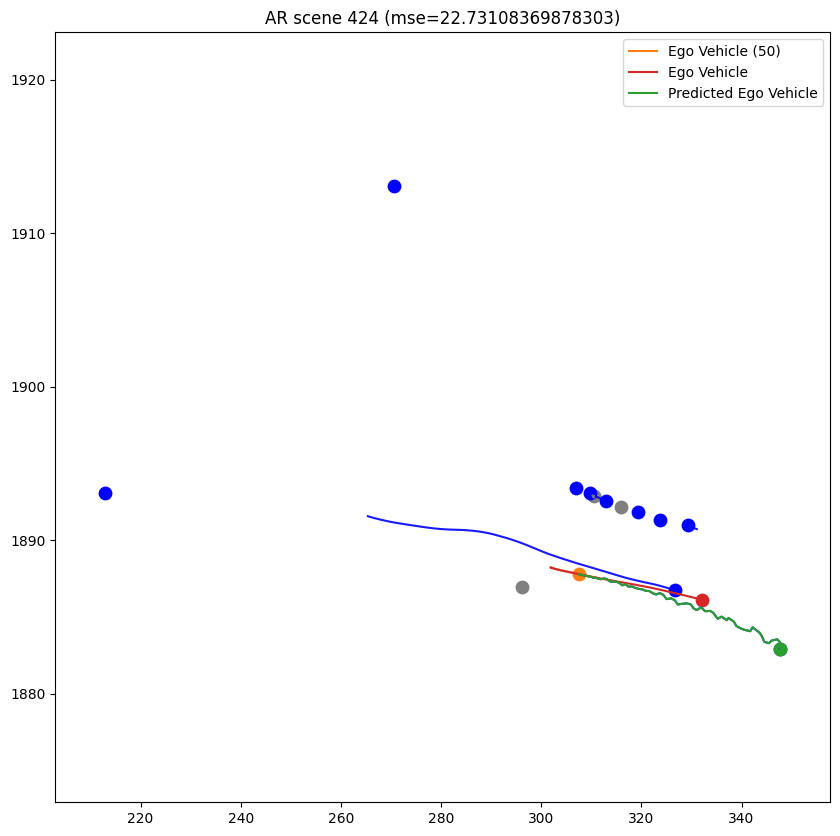

In [153]:
## AR is over-predicting stopped agent
s = 424
plot_scene_pred(s, lstm_scenes, lstm_mse, f'AR scene {s}') 